# АНСАМБЛИ МОДЕЛЕЙ

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline

## Часть 0. Деревья решений

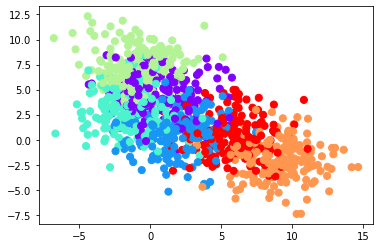

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=6,
                  random_state=0, cluster_std=2.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.show()

In [17]:
def visualize_tree(estimator, X, y, ax=None, fit=True):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    if fit:
        estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

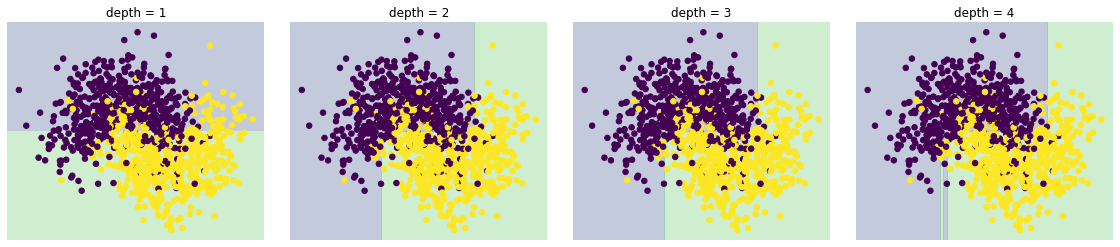

In [18]:
from sklearn.tree import DecisionTreeClassifier
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)
for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi, fit=True)
    axi.set_title('depth = {0}'.format(depth))

### Переобучение деревьев
К сожалению, деревья решений склонны к переобучению. Пример - обучим два дерева решений на половине данных и сравним результаты

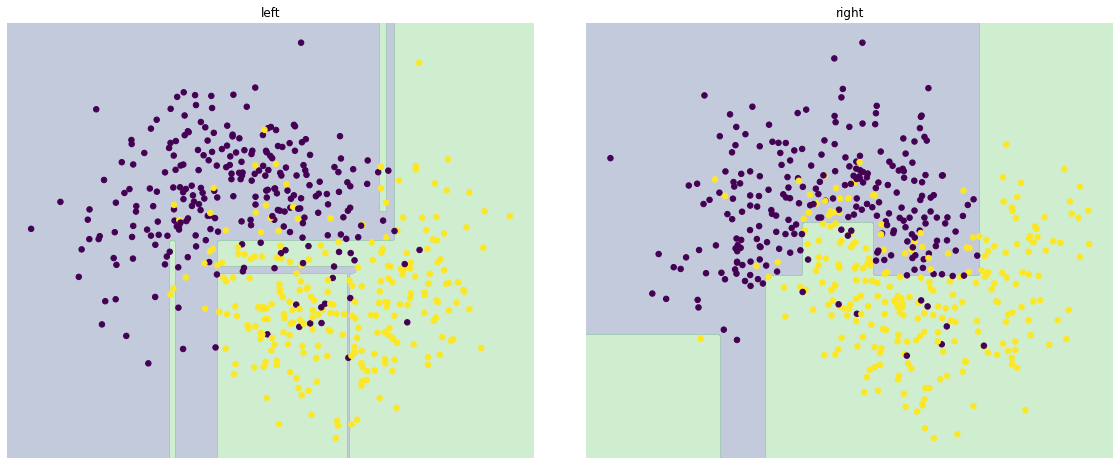

In [19]:
boundary = int(len(X) / 2)
X_left, y_left, X_right, y_right = X[:boundary], y[:boundary], X[boundary:], y[boundary:]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

model_left = DecisionTreeClassifier(max_depth=5)
visualize_tree(model_left, X_left, y_left, ax=ax[0])
ax[0].set_title('left')

model_right = DecisionTreeClassifier(max_depth=5)
visualize_tree(model_right, X_right, y_right, ax=ax[1])
ax[1].set_title('right')
plt.show()

# Часть 1 - Ансамбли

### Теорема Кондорсе «о жюри присяжных» (1784).
Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных.


$N$ — количество присяжных

$p$ — вероятность правильного решения присяжного

$μ$— вероятность правильного решения всего жюри

$m$ — минимальное большинство членов жюри, $m = \text{floor}(N/2) + 1$

$C^i_N$ - число сочетаний из $N$ по $i$

$$\large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i}$$

Если $p>0.5$, то $\mu>p$

Если $N \rightarrow \infty$, то $\mu \rightarrow 1$

# Часть 2 - Беггинг

Беггинг - общий подход к уменьшению дисперсии алгоритма машинного обучения. Беггинг происходит от фразы bootstrap aggregation. Bootstrap выборка - это просто выборка с повторением

Общий алгоритм:
1. Генерируем подвыборку $X_i$ размера $N$ с возвращением
2. Обучим базовый алгоритм $a_i(x)$ на выборке $X_i$
3. Повторяем шаги 1-2 $M$ раз
4. Усредняем (регрессия) или проводим голосование среди ответов $a_i(x)$

Замечания:

- Каждую подвыборку обычно делают размером с оригинальный набор данных
- Количество подвыборок должно быть достаточно, чтобы итоговая ошибка "стабилизировалась"

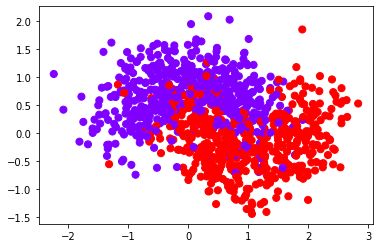

In [20]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=123)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.show()

In [21]:
# Поделим на train и тест
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

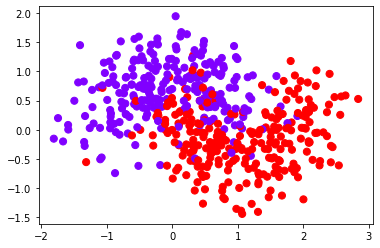

In [22]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='rainbow')
plt.show()

## Реализуем беггинг над деревьями решений для этого примера (10 деревьев)

In [23]:
estimators = 10
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(estimators)]

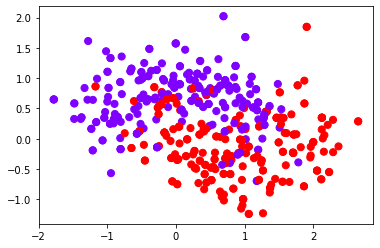

In [24]:
plt.scatter(X_train[samples[3], 0], X_train[samples[3], 1], c=y_train[samples[3]], s=50, cmap='rainbow')
plt.show()

In [25]:
models = []
for sample in samples:
    model = DecisionTreeClassifier(max_depth=None)
    model.fit(X_train[sample], y_train[sample])
    models.append(model)

In [26]:
def predict(models, X):
    predictions = None
    for m in models:
        if predictions is None:
            predictions = m.predict(X).reshape((-1, 1))
        else:
            predictions = np.hstack((predictions, m.predict(X).reshape((-1, 1))))
    result = []
    for p in predictions:
        result.append(np.bincount(p).argmax())
    return np.array(result)

In [27]:
y_pred = predict(models, X_test)
print(np.mean(y_pred == y_test))
print("MODELS")
for m in models:
    print(np.mean(m.predict(X_test) == y_test))

0.86
MODELS
0.828
0.816
0.832
0.834
0.822
0.828
0.844
0.834
0.856
0.836


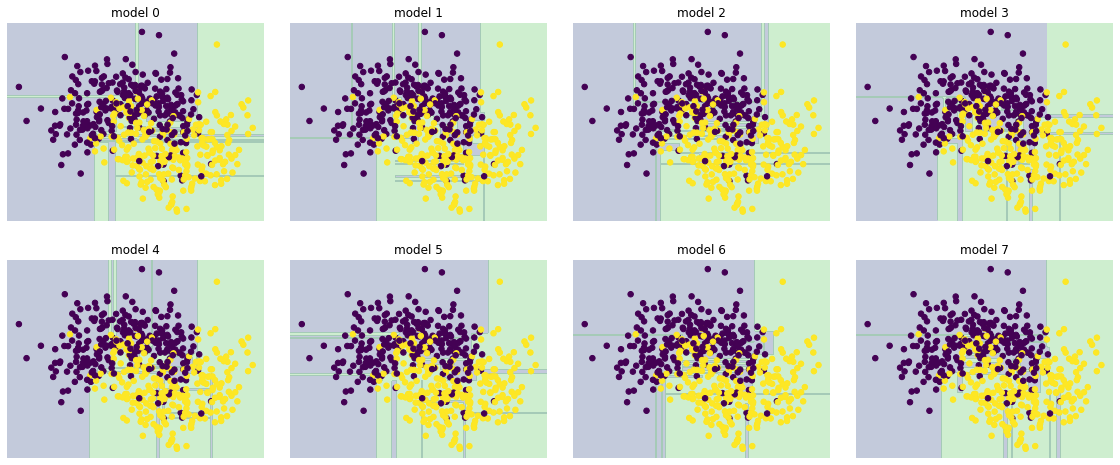

In [28]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)
for axi, index in zip(ax.flatten(), range(8)):
    visualize_tree(models[index], X_train, y_train, ax=axi, fit=False)
    axi.set_title('model {}'.format(index))

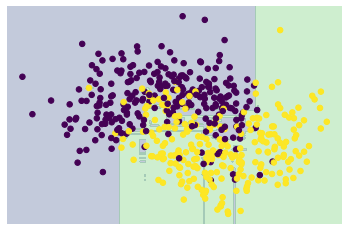

In [29]:
def visualize_bagg(models, X, y):
    ax = plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')

    xlim = ax.get_xlim()    
    ylim = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = predict(models, np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(Z))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
visualize_bagg(models, X_train, y_train)

### Практический пример

Используем данные страхового подразделения BNP Paribas из соревнования

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management

Решается задача классификации страховых случаев:

1. Случаи, требующие дополнительных документов для подтвердения (0)    
2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

In [30]:
data = pd.read_csv('train.csv')

FileNotFoundError: [Errno 2] File train.csv does not exist: 'train.csv'

In [31]:
# Уменьшим размер данных для ускорения обучения, возьмем случайную подвыборку 20% данных
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

NameError: name 'data' is not defined

In [32]:
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

NameError: name 'data' is not defined

In [33]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

NameError: name 'data' is not defined

In [34]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

NameError: name 'd_train' is not defined

Обучаем решающее дерево

Немного ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

In [35]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)

In [36]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Train:
ROC AUC: 0.9480
Test:
ROC AUC: 0.9360


0.9360384153661465

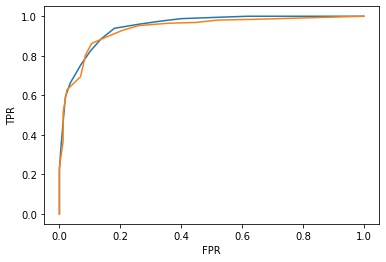

In [37]:
y_pred_test = clf_tree.predict_proba(X_test)[:, 1]
y_pred_train = clf_tree.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_pred_test, 'test')

## Применим беггинг к реальным данным

Используем готовый алгоритм из sklearn

In [38]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                        min_samples_leaf=20),
                  n_estimators=20, n_jobs=-1)

Train:
ROC AUC: 0.9409
Test:
ROC AUC: 0.9476


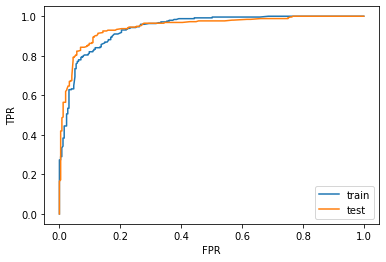

In [39]:
y_pred_test = bag_clf.predict_proba(X_test)[:, 1]
y_pred_train = bag_clf.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_pred_train, 'train')
print('Test:')
show_auc(y_test, y_pred_test, 'test')
plt.legend();

# Часть 3. Случайный лес

Бэггинг + случайные подпространства = случайный лес

Случайный лес - вариация беггинга над деревьями, дающая даже лучшие результаты:
Как и в беггинге, мы создаем ансамбль деревьев решений, используя выборки из обучающего набора.
Однако при построении каждого дерева каждый раз, когда производится расщепление, признак выбирается из случайной выборки размера m из всех признаков.
Новая случайная выборка признаков формируется для каждого отдельного дерева в каждом отдельном расщеплении.
Для классификации $m$ обычно выбирается как квадратный корень из $p$.
Для регрессии $m$ обычно выбирается где-то между $p / 3$ и $p$.

В чем смысл?
Предположим, что в наборе данных есть один очень сильный признак. При использовании беггинга большая часть деревьев будет использовать этот признак в качестве первого, по которому производится деление, в результате чего образуется ансамбль похожих деревьев, которые сильно коррелированы.
Усреднение высококоррелированных величин не приводит к значительному уменьшению дисперсии (что является целью беггинга).
Случайно исключая признаки из каждого расщепления, Random Forest «декоррелирует» деревья, так что процесс усреднения может уменьшить дисперсию результирующей модели.

**Важные гиперпараметры алгоритма**

a. Параметры деревьев
1. criterion - критерий построения дерева
2. max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)

b. Параметры леса
1. n_estimators - кол-во деревьев (чем больше тем лучше)
2. max_features - число признаков случайного подпространства
3. bootstrap - использовать ли бэггинг
4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

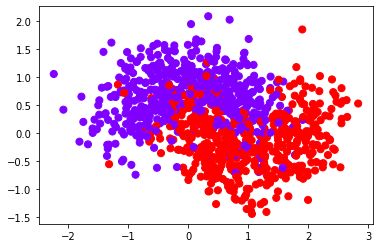

In [40]:
mX, my = make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=123)

mX_train, mX_test, my_train, my_test = train_test_split(mX, my, test_size=0.3)

plt.scatter(mX[:, 0], mX[:, 1], c=my, s=50, cmap='rainbow')
plt.show()

In [41]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(mX_train, my_train)   

bag_clf = BaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(), n_jobs=-1)
bag_clf.fit(mX_train, my_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_jobs=-1)

Train RF:
ROC AUC: 0.9424
Test RF:
ROC AUC: 0.9496
Train BAG:
ROC AUC: 0.9995
Test BAG:
ROC AUC: 0.9231


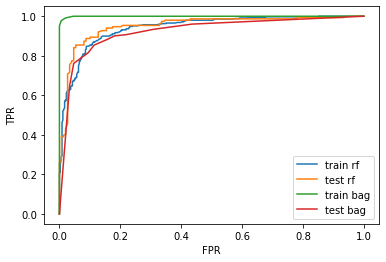

In [42]:
my_pred_test_rf = clf_rf.predict_proba(mX_test)[:, 1]
my_pred_train_rf = clf_rf.predict_proba(mX_train)[:, 1]
my_pred_test_bag = bag_clf.predict_proba(mX_test)[:, 1]
my_pred_train_bag = bag_clf.predict_proba(mX_train)[:, 1]

print('Train RF:')
show_auc(my_train, my_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(my_test, my_pred_test_rf, 'test rf')
print('Train BAG:')
show_auc(my_train, my_pred_train_bag, 'train bag')
print('Test BAG:')
show_auc(my_test, my_pred_test_bag, 'test bag')

plt.legend();

## Применим случайный лес к нашему dataset'у

In [43]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)    

RandomForestClassifier(max_depth=5, max_features=0.5, min_samples_leaf=20,
                       n_estimators=10, n_jobs=-1)

Train RF:
ROC AUC: 0.9372
Test RF:
ROC AUC: 0.9450
Train:
ROC AUC: 0.9409
Test:
ROC AUC: 0.9476


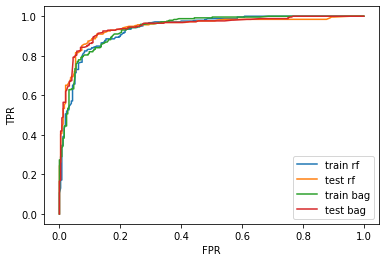

In [44]:
y_pred_test_rf = clf_rf.predict_proba(X_test)[:, 1]
y_pred_train_rf = clf_rf.predict_proba(X_train)[:, 1]


print('Train RF:')
show_auc(y_train, y_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(y_test, y_pred_test_rf, 'test rf')
print('Train:')
show_auc(y_train, y_pred_train, 'train bag')
print('Test:')
show_auc(y_test, y_pred_test, 'test bag')
plt.legend();

plt.legend();

#### Важность признаков
В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

In [45]:
imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False)

1    0.628832
0    0.371168
dtype: float64

Плюсы random_forest:
- устойчив к переобучению
- устойчивость к выбросам
- дает хорошее качество “из коробки”
- встроенная оценка важности признаков
- быстрая реализация

Минусы:
- сложность интерпретации по сравнению с одним деревом
- плохо справляется с очень большим числом признаков
- работает дольше линейных моделей

# Часть 4. Композиции моделей разных типов

Главная идея - почему ансамблирование моделей делается таким простым способом, как усреднение? Что если доверить это делому другому алгоритму машинного обучения?

## Блендинг
<img src="img/stacking.png" style="max-width: 680px; display: inline" />

Основной недостаток - деление обучающей выборки. Никакой из алгоритмов не использует всех данных для обучения.

## Стекинг

Используем идею K-Fold проверки. Выборку разбиваем на фолды, затем последовательно перебираем фолды и обучаем базовые алгоритмы на всех фолдах, кроме одного, а на оставшемся получаем ответы базовых алгоритмов и трактуем их как значения соответствующих признаков на этом фолде. Для получения метапризнаков объектов тестовой выборки базовые алгоритмы обучают на всей обучающей выборке и берут их ответы на тестовой.

<img src="img/stacking-2b.png" style="max-width: 680px; display: inline" />

### Смешаем дерево и логистическую регрессию


### Готовим признаки

In [46]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train[num_feat] = scaler.transform(X_train[num_feat])
X_test[num_feat] = scaler.transform(X_test[num_feat])

NameError: name 'd_train' is not defined

## обучим стекинг

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
classifier = StackingClassifier(
    [
        ('lr', LogisticRegression()),
        ('dt', DecisionTreeClassifier())
    ],
LogisticRegression())

In [47]:
classifier.fit(X_train, y_train)

NameError: name 'classifier' is not defined

In [48]:
classifier.named_estimators_['lr']

NameError: name 'classifier' is not defined

In [49]:
y_pred_proba_lr = classifier.named_estimators_['lr'].predict_proba(X_test)[:,1]

NameError: name 'classifier' is not defined

In [50]:
y_pred_proba_dt = classifier.named_estimators_['dt'].predict_proba(X_test)[:,1]

NameError: name 'classifier' is not defined

In [51]:
y_pred_proba = classifier.predict_proba(X_test)[:,1]

NameError: name 'classifier' is not defined

In [52]:
print("LR")
show_auc(y_test, y_pred_proba_lr, 'LR')
print("DT")
show_auc(y_test, y_pred_proba_dt, 'DT')
print("STACK")
show_auc(y_test, y_pred_proba, 'STACK')
plt.legend()
plt.show()

LR


NameError: name 'y_pred_proba_lr' is not defined

#### Посмотрим на коэффициенты объединяющей линейной модели

In [53]:
classifier.final_estimator_

NameError: name 'classifier' is not defined

In [54]:
pd.Series(classifier.final_estimator_.coef_.flatten(), index=classifier.named_estimators_.keys()).plot(kind='barh')

NameError: name 'classifier' is not defined

# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Построить случайный лес, вывести важность признаков
3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
4. В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [55]:
train_data = pd.read_csv('train.csv')
description =  open('data_description.txt')
### for line in description: 
###    print(line) очень длинное описание 

FileNotFoundError: [Errno 2] File train.csv does not exist: 'train.csv'

In [56]:
train_data.head(10)

NameError: name 'train_data' is not defined

In [57]:
col_list = train_data.columns

NameError: name 'train_data' is not defined

In [58]:
train_data.info()
train_data.replace("NaN", np.nan)

NameError: name 'train_data' is not defined

In [59]:
list_int_object = []
for x in col_list: 
    if train_data[x].dtypes == "int" or train_data[x].dtypes == "object":
        list_int_object.append(x)
print(list_int_object)


NameError: name 'col_list' is not defined

In [ ]:
nan_list = []
for _ in col_list:
    if not (_ in list_int_object):
        nan_list.append(_)
nan_list

In [ ]:
train_data = pd.get_dummies( train_data, columns = list_int_object )

In [ ]:
for _ in nan_list[2::]:
    if train_data[_].isna().sum() > 0: 
        nan = np.nan
        train_data[f'{_}_nan1'] = np.where(nan, 1, 0)


In [ ]:
train_data = train_data.replace(np.nan, -99999)
del train_data['ID']


In [ ]:
train_data.head(20)
y = train_data['target']
del train_data['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.3)

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=1000, max_depth= 5, min_samples_leaf=27, max_features= 'auto', n_jobs=-1)

In [ ]:
clf_rf.fit(X_train, y_train)  

In [ ]:
my_pred_test_rf = clf_rf.predict_proba(X_test)[:, 1]
my_pred_train_rf = clf_rf.predict_proba(X_train)[:, 1]

print('Train RF:')
show_auc(y_train, my_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(y_test, my_pred_test_rf, 'test rf')

plt.legend();

# Надобы ещё пооптимимизировать..... 


In [ ]:
clf_rf.score(X_test,  y_test)

In [ ]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': clf_rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(100)

In [ ]:
best_params = list(X_train.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data[best_params[:101:]], y, test_size=0.3)
clf_rf = RandomForestClassifier(n_estimators=1000, max_depth= 5, min_samples_leaf=27, max_features= 'auto', n_jobs=-1)
clf_rf.fit(X_train, y_train) 
my_pred_test_rf = clf_rf.predict_proba(X_test)[:, 1]
my_pred_train_rf = clf_rf.predict_proba(X_train)[:, 1]

print('Train RF:')
show_auc(y_train, my_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(y_test, my_pred_test_rf, 'test rf')

plt.legend();

In [ ]:
clf_rf.score(X_test,  y_test)

In [ ]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': clf_rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(100)

### Вторая Часть 

In [ ]:
train_data = pd.read_csv('train.csv')
col_list = train_data.columns
train_data.info()
train_data.replace("NaN", np.nan)
list_int_object = []
for x in col_list: 
    if train_data[x].dtypes == "int" or train_data[x].dtypes == "object":
        list_int_object.append(x)
print(list_int_object)
nan_list = []
for _ in col_list:
    if not (_ in list_int_object):
        nan_list.append(_)
nan_list

#Находим категориальные признаки
cat_feat = list(train_data.dtypes[train_data.dtypes == object].index)
cat_feat1 = list(train_data.dtypes[train_data.dtypes == int].index)
cat_feat = cat_feat + cat_feat1
#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
train_data[cat_feat] = train_data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in train_data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

dell_cat = []
for _ in list_int_object:
    if not (_ in cat_feat):
        dell_cat.append(_)

print(dell_cat)
for _ in dell_cat:
    del train_data[f'{_}']

In [ ]:

train_data = pd.get_dummies( train_data, columns = cat_feat )
for _ in nan_list[2::]:
    if train_data[_].isna().sum() > 0: 
        nan = np.nan
        train_data[f'{_}_nan1'] = np.where(nan, 1, 0)
train_data = train_data.replace(np.nan, -99999)
del train_data['ID']
train_data.head(20)
y = train_data['target']
del train_data['target']

In [ ]:
train_data = train_data.replace(-99999, np.nan)
train_data = train_data.fillna(train_data.mean())
train_data.head()


In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
d_train = train_data     
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.3)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classifier = StackingClassifier(
    [
        ('lr', LogisticRegression(solver='lbfgs', max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=1000, max_depth= 5, min_samples_leaf=27, max_features= 'auto', n_jobs=-1)),
        ('clf',LinearDiscriminantAnalysis())
    ],
LogisticRegression())

In [ ]:
classifier.fit(X_train, y_train)
classifier.score(X_test,  y_test)

In [ ]:
classifier.named_estimators_['lr']
y_pred_proba_lr = classifier.named_estimators_['lr'].predict_proba(X_test)[:,1]
y_pred_proba_rf = classifier.named_estimators_['rf'].predict_proba(X_test)[:,1]
y_pred_proba_clf = classifier.named_estimators_['clf'].predict_proba(X_test)[:,1]
y_pred_proba = classifier.predict_proba(X_test)[:,1]



In [ ]:
print("LR")
show_auc(y_test, y_pred_proba_lr, 'LR')
print("RF")
show_auc(y_test, y_pred_proba_rf, 'RF')
print("CLF")
show_auc(y_test, y_pred_proba_clf, 'CLF')
print("STACK")
show_auc(y_test, y_pred_proba, 'STACK')
plt.legend()
plt.show()

# Спасибо за проверку! 